# Mixture of Experts model (MoE)

Real-world processes are often complex, with underlying patterns and behaviors that can vary significantly across different contexts. Modeling these processes effectively requires approaches that can handle such variability and adapt to different scenarios dynamically. In the world of Gaussian Proccesses (GPs) one powerful method for achieving this is the Mixture of Experts model.

A Mixture of Experts model combines multiple expert models to handle different parts of the input space. Each expert is specialized in a particular region or aspect of the data, and a gating network decides which expert (or combination of experts) should be used for a given input. This modular approach allows for more flexible and accurate modeling of complex data.

This notebook will cover:

* Limitations of classic stationary Gaussian Procceses in context of non stationary data
* How to use use **twinLab** to create, train and use a Mixture of Experts model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.10.0
          User        : sergio@digilab.co.uk
          Server      : http://127.0.0.1:8000
          Environment : /Users/sergiochavez/twinlab-tutorials/.env



## 1. Limitations of classic stationary Gaussian Procceses

Consider an underlying data generating process that varies a lot on one part of the domain and less on another part of the domain. 




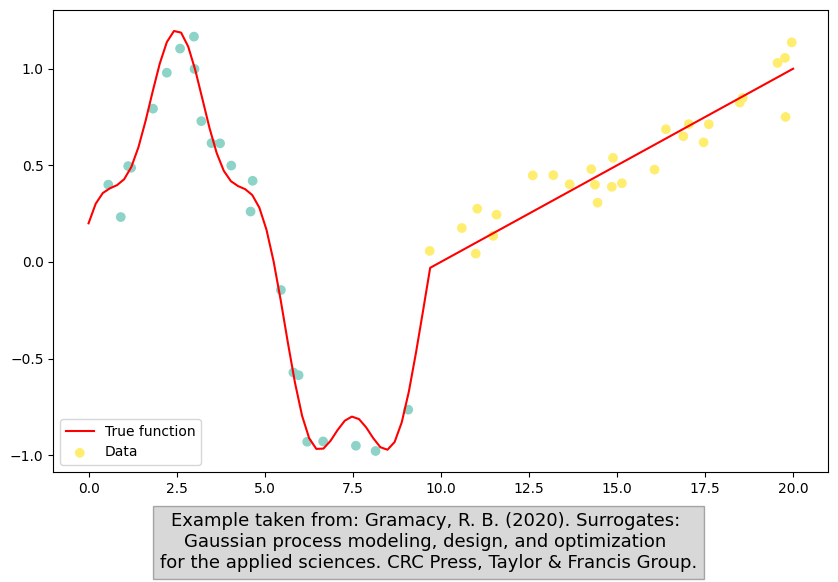

In [2]:
# Define the model that generates the data
np.random.seed(421)
def model(x):
    y = (np.sin(np.pi * x/5) + 0.2*np.cos(4 * np.pi * x/5)) * (x <= 9.6)
    lin = x > 9.6
    y[lin] = -1 + x[lin]/10
    return y

# Generate data
X = np.linspace(0, 20, 100)
y = model(X)

X_data = 20*np.random.uniform(size=50)
y_data = model(X_data) + 0.1*np.random.normal(size=X_data.size)
class_data = (X_data > 9.6).astype("float")

# Plot functions
plt.figure(figsize=(10,6))
plt.plot(X, y, label="True function", c="r")
plt.scatter(X_data, y_data, c=class_data, label="Data", cmap="Set3")
plt.figtext(0.5, -0.05, "Example taken from: Gramacy, R. B. (2020). Surrogates: \nGaussian process modeling, design, and optimization \nfor the applied sciences. CRC Press, Taylor & Francis Group.", ha="center", fontsize=13, bbox={"facecolor":"grey", "alpha":0.3, "pad":5})

plt.legend()
plt.show()

df = pd.DataFrame({"X": X_data, "y": y_data, "class": class_data})

Using a standard (stationary) GP, the predictive variance is overestimated for the area of the domain with little inherent variance.

Emulator classic_gp_emulator has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator classic_gp_emulator is complete!


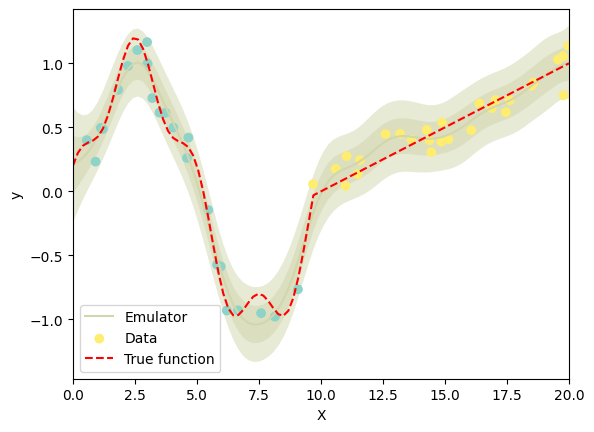

In [3]:
# Instantiate Dataset object and upload data
dataset = tl.Dataset(id="mixture_of_experts_df")
dataset.upload(df)

# Instatiate emulator
emulator=tl.Emulator(id="classic_gp_emulator")

# Train a standard stationary GP emulator
emulator.train(dataset, inputs=["X"], outputs=["y"])

# Plot the emulator
emulator.plot(x_axis="X", y_axis="y", x_lim=(0, 20), color="#D1D6AD")
plt.scatter(X_data, y_data, c=class_data, label="Data", cmap="Set3")
plt.plot(X, y, label="True function", c="r", linestyle="dashed")
plt.legend()
plt.show()

As the plot shows, we get very high predictive variance on the right side of the domain because of the underlying stationary GP. 

Using a Mixture of Experts Model will account the different regions and patterns of the datapoints, fiting specialized (experts) GPs to them. 

## 2. How to use use **twinLab** to create, train and use a Mixture of Experts model

Considerig the same scenario, lets create and train an twinLab emulator that use a Mixture of Experts model. 

First, note that we will need the different classes that are governed by different experts to be labelled in the training dataframe in advance. Here, they are specified in the "class" column:

In [4]:
df.head()

,X,y,class
0,13.655640,0.402193,1.0
1,16.066217,0.477974,1.0
2,1.125503,0.496038,0.0
3,19.769547,1.056062,1.0
4,4.050445,0.498828,0.0


To use Model of Experts in **twinLab** for this case we will have to:

* Specify the type of estimator we want (***"mixture_of_experts_gp"***) inside **tl.EstimatorParams()**
* Specify the label of the class column (in this case ***"class"***) inside **tl.TrainParams()**
* Include the defined **tl.TrainParams()** inside the training process of the emulator along with the inputs and outputs to be considered from the dataset.

In [5]:
# Instantiate Dataset object and upload data
dataset = tl.Dataset(id="mixture_of_experts_df")
dataset.upload(df)

# Instatiate emulator
emulator_MoE=tl.Emulator(id="mixture_of_experts_emulator")

# Train the emulator
estimator_params=tl.EstimatorParams(estimator_type="mixture_of_experts_gp")
train_params=tl.TrainParams(estimator_params=estimator_params, class_column="class")
emulator_MoE.train(dataset, inputs=["X"], outputs=["y"], params=train_params)

Emulator mixture_of_experts_emulator has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator mixture_of_experts_emulator is complete!


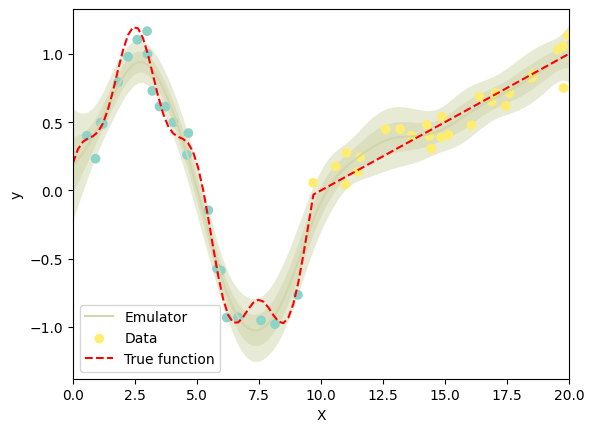

In [6]:
# Plot results of training
emulator_MoE.plot(x_axis="X", y_axis="y", x_lim=(0, 20), color="#D1D6AD")
plt.scatter(X_data, y_data, c=class_data, label="Data", cmap="Set3")
plt.plot(X, y, label="True function", c="r", linestyle="dashed")
plt.legend()
plt.show()

As you can see, the twinLab Mixture of Experts model fits the training data better than the previous image where a standard stationary GP was used.

Once the emulator is trained, the **twinLab** Mixture of Experts is ready to be used.

Lets now predict the outcome for a new set of datapoints and compare the results with the predictions coming from a standard stationary GP.

In [7]:
# Change seed to generate different data
np.random.seed(765)

# Generate new input to predict
X = np.linspace(0, 20, 100)

X_data = 20*np.random.uniform(size=20)
eval_df = pd.DataFrame({"X": X_data})

Notice that we can follow the same procedure to run predict for a Mixture of Experts model

In [8]:
# Predict outcomes using the standard GP emulator
mean_predictions, std_predictions = emulator.predict(eval_df, verbose=False)

# Predict outcomes using the Mixture of Experts GP emulator
mean_predictions_MoE, std_predictions_MoE = emulator_MoE.predict(eval_df, verbose=False)

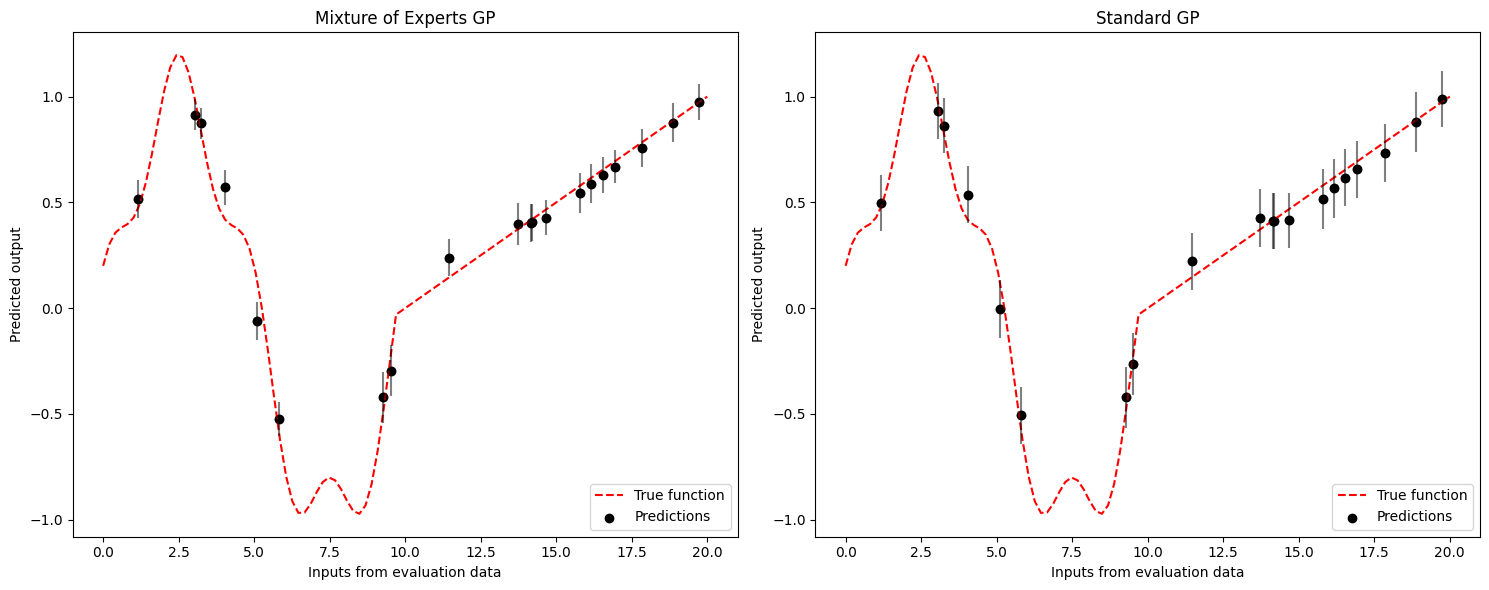

In [9]:
#Include predictions in the dataframe
eval_df["mean_predictions_MoE"] = mean_predictions_MoE
eval_df["std_predictions_MoE"] = std_predictions_MoE
eval_df["mean_predictions"] = mean_predictions
eval_df["std_predictions"] = std_predictions

## Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Mixtures of Experts GP
axes[0].plot(X, model(X), label="True function", c="r", linestyle="dashed")
axes[0].scatter(eval_df['X'], eval_df['mean_predictions_MoE'], c="black", label="Predictions")
axes[0].errorbar(eval_df['X'], eval_df['mean_predictions_MoE'], yerr=eval_df['std_predictions_MoE'], fmt='o', color="black", alpha=0.5)
axes[0].legend(loc='lower right')
axes[0].set_xlabel('Inputs from evaluation data')  
axes[0].set_ylabel('Predicted output') 
axes[0].set_title("Mixture of Experts GP")
# Standard GP
axes[1].plot(X, model(X), label="True function", c="r", linestyle="dashed")
axes[1].scatter(eval_df['X'], eval_df['mean_predictions'], c="black", label="Predictions")
axes[1].errorbar(eval_df['X'], eval_df['mean_predictions'], yerr=eval_df['std_predictions'], fmt='o', color="black", alpha=0.5)
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Inputs from evaluation data')
axes[1].set_ylabel('Predicted output')
axes[1].set_title("Standard GP")

plt.tight_layout()
plt.show()


The plot shows how the predictions of the Mixture of Experts model are more accurate and closer to the underlying real function. This can be better appreciated comparing the error bars of the predictions, where it is showed that the uncertainty is lower than the predictions coming from the standard GP.

In [10]:
# Delete standard emulator and dataset
emulator.delete()
dataset.delete()

# Delete MoE emulator 
emulator_MoE.delete()
